## Importing Libraries

In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import sys
module_path = "../../src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.encoding import ClassicEncoding,TargetEncoding
from modeling.regression import Trainer_Boosting
from lofo import LOFOImportance, Dataset, plot_importance
from utils.utils import *
pd.options.display.max_rows = 999
DATA_PATH = '../../Data'
PATH_MODEL = '../../SavedModels/model_behavior' 
PROJECT_NAME = 'MODEL_BEHAVIOR'
GROUP_NAME = 'lightgbm_v0_behavior_mes_202004'
FILL_NA  = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
train_all,test_all = get_reference_datasets(DATA_PATH)

In [12]:
cat_features = ['tipo_seg','categoria','tipo_com','tipo_cat','tipo_cli','tipo_ban','tipo_seg_and_tipo_ban']
drop_cols = ['VAR9_sum','VAR9_prom','VAR26_sum','VAR26_trx','VAR9_trx','VAR10_sum','VAR18_sum','VAR20_sum','VAR19_sum','tipo_ban_group']

In [13]:
%%time
train_df = get_train_data('folds_behavior_clients_model.parquet.gzip',DATA_PATH = DATA_PATH )[['id','mes','fold','target_mes']]
test_df  = get_test_data(segment = 'behavior_future',DATA_PATH = DATA_PATH)[['id','mes']]
features = pd.read_parquet(os.path.join(DATA_PATH,'DatasetsGenerated','features_v1','features.parquet'))
train_df = train_df.merge(features,on = ['id','mes'],how = 'left')
test_df  = test_df.merge(features,on = ['id','mes'],how = 'left')
print('Train & Test shape:',train_df.shape,test_df.shape)

target_features = pd.read_parquet(os.path.join(DATA_PATH,'DatasetsGenerated','features_v1','target_features.parquet'))
train_df = train_df.merge(target_features,on = ['id','mes'],how = 'left')
test_df  = test_df.merge(target_features,on = ['id','mes'],how = 'left')
train_df = train_df[train_df['mes']>=202004].reset_index(drop = True)
print('Train & Test shape:',train_df.shape,test_df.shape)

Train & Test shape: (667691, 253) (91270, 251)
Train & Test shape: (312256, 282) (91270, 280)
CPU times: user 15 s, sys: 13.2 s, total: 28.2 s
Wall time: 24.8 s


In [14]:
enc = ClassicEncoding(cat_features,name_encoding = 'LE')
train_df = enc.fit_transform(train_df)
test_df  = enc.transform(test_df)

Mode: Missing as new category
Label Encoding:  label_tipo_seg
Label Encoding:  label_categoria
Label Encoding:  label_tipo_com
Label Encoding:  label_tipo_cat
Label Encoding:  label_tipo_cli
Label Encoding:  label_tipo_ban
Label Encoding:  label_tipo_seg_and_tipo_ban
Mode: Missing as new category
Applying Label Encoding:  label_tipo_seg
Applying Label Encoding:  label_categoria
Applying Label Encoding:  label_tipo_com
Applying Label Encoding:  label_tipo_cat
Applying Label Encoding:  label_tipo_cli
Applying Label Encoding:  label_tipo_ban
Applying Label Encoding:  label_tipo_seg_and_tipo_ban


In [15]:
def sqrt_mae_lgbm(preds,data):
    from sklearn.metrics import mean_absolute_error
    """Calculate exp_mae_metric"""
    labels = data.get_label()
    metric = mean_absolute_error(labels**2,preds**2)
    return 'sqrt_mae', metric, False

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='target_mes', ylabel='Density'>

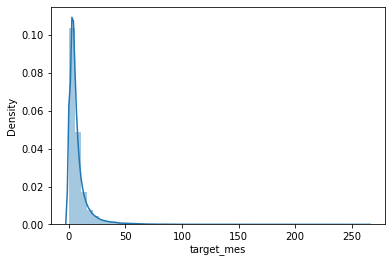

In [16]:
import seaborn as sns
train_df['target_mes'] = np.sqrt(train_df['target_mes'])
sns.distplot(train_df['target_mes'])

In [12]:
model_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'learning_rate': 0.15,
        'num_leaves':48,
        'metric': 'None',
        "min_child_samples": 20,
        "max_depth" : 7,
        'feature_fraction':  0.7,
        "bagging_freq": 1, # at K iterations perform bagging
        'bagging_fraction': 0.75, # percentage of bagging
        'force_col_wise':True,
        'cat_smooth': 100, 
        'bagging_seed':42,
        'lambda_l1':2.5,
        'lambda_l2':2.0,
        'verbose': -1,
        'n_jobs':48

}
cat_columns = [i for i in train_df.columns.to_list() if i.startswith('label_')]
trainer = Trainer_Boosting(train_df.drop(columns = ['id','mes'] + drop_cols),
                           model_params,
                           train_params = {'model_name'      : 'lightgbm',
                                           'fold_column'     : 'fold',
                                           'target_column'   : 'target_mes',
                                           'cat_vars'        : cat_columns,
                                           'metric'          : 'sqrt_mae',
                                           'feval'           : sqrt_mae_lgbm,
                                           'early_stopping'  : 200,
                                           'max_boost_round' : 16000,
                                           'run_wandb'       : True,
                                           'project_name'    : PROJECT_NAME,
                                           'group_name'      : GROUP_NAME}
                          )
trainer.train()

Features for training: ['VAR1_sum', 'VAR1_prom', 'VAR1_trx', 'VAR2_sum', 'VAR2_prom', 'VAR2_trx', 'VAR3_sum', 'VAR3_prom', 'VAR3_trx', 'VAR4_sum', 'VAR4_prom', 'VAR4_trx', 'VAR5_sum', 'VAR5_prom', 'VAR5_trx', 'VAR6_sum', 'VAR6_prom', 'VAR6_trx', 'VAR7_sum', 'VAR7_prom', 'VAR7_trx', 'VAR8_sum', 'VAR8_prom', 'VAR8_trx', 'VAR11_sum', 'VAR12_sum', 'VAR13_sum', 'VAR14_sum', 'VAR15_sum', 'VAR16_sum', 'VAR17_sum', 'VAR21_sum', 'VAR22_sum', 'VAR23_sum', 'VAR23_prom', 'VAR23_trx', 'VAR24_sum', 'VAR24_prom', 'VAR24_trx', 'VAR25_sum', 'VAR25_prom', 'VAR25_trx', 'VAR26_prom', 'VAR27_sum', 'VAR27_prom', 'VAR27_trx', 'VAR28_sum', 'VAR28_prom', 'VAR28_trx', 'VAR29_prom', 'VAR29_ratio', 'VAR30_sum', 'count_nan', 'tipo_seg_prod_0', 'tipo_seg_prod_1', 'tipo_seg_prod_2', 'tipo_seg_prod_3', 'ratio_VAR1_sum_trx', 'ratio_VAR3_sum_trx', 'ratio_VAR25_sum_trx', 'ratio_VAR4_sum_trx', 'ratio_VAR24_sum_trx', 'ratio_VAR23_sum_trx', 'ratio_VAR1_sum_prom', 'ratio_VAR3_sum_prom', 'ratio_VAR25_sum_prom', 'ratio_VAR4_s

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[50]	training's sqrt_mae: 71.2111	valid_1's sqrt_mae: 74.1211
[100]	training's sqrt_mae: 65.6696	valid_1's sqrt_mae: 69.7401
[150]	training's sqrt_mae: 61.3767	valid_1's sqrt_mae: 66.609
[200]	training's sqrt_mae: 58.2269	valid_1's sqrt_mae: 64.5514
[250]	training's sqrt_mae: 55.824	valid_1's sqrt_mae: 63.0656
[300]	training's sqrt_mae: 54.0362	valid_1's sqrt_mae: 62.1325
[350]	training's sqrt_mae: 52.8416	valid_1's sqrt_mae: 61.5441
[400]	training's sqrt_mae: 51.9308	valid_1's sqrt_mae: 61.1918
[450]	training's sqrt_mae: 50.8884	valid_1's sqrt_mae: 60.7576
[500]	training's sqrt_mae: 50.1545	valid_1's sqrt_mae: 60.4642
[550]	training's sqrt_mae: 49.4136	valid_1's sqrt_mae: 60.162
[600]	training's sqrt_mae: 48.6913	valid_1's sqrt_mae: 59.8952
[650]	training's sqrt_mae: 48.1084	valid_1's sqrt_mae: 59.7206
[700]	training's sqrt_mae: 47.6259	valid_1's sqrt_mae: 59.5528
[750]	training's sqrt_mae: 46.941	valid_1's sqrt_mae: 59.276

[6450]	training's sqrt_mae: 32.8435	valid_1's sqrt_mae: 55.3573
[6500]	training's sqrt_mae: 32.8037	valid_1's sqrt_mae: 55.3449
[6550]	training's sqrt_mae: 32.7735	valid_1's sqrt_mae: 55.3414
[6600]	training's sqrt_mae: 32.7358	valid_1's sqrt_mae: 55.3323
[6650]	training's sqrt_mae: 32.7032	valid_1's sqrt_mae: 55.3239
[6700]	training's sqrt_mae: 32.6715	valid_1's sqrt_mae: 55.3216
[6750]	training's sqrt_mae: 32.6394	valid_1's sqrt_mae: 55.3191
[6800]	training's sqrt_mae: 32.6079	valid_1's sqrt_mae: 55.3141
[6850]	training's sqrt_mae: 32.5751	valid_1's sqrt_mae: 55.3088
[6900]	training's sqrt_mae: 32.5297	valid_1's sqrt_mae: 55.3035
[6950]	training's sqrt_mae: 32.501	valid_1's sqrt_mae: 55.3023
[7000]	training's sqrt_mae: 32.4633	valid_1's sqrt_mae: 55.297
[7050]	training's sqrt_mae: 32.4347	valid_1's sqrt_mae: 55.2989
[7100]	training's sqrt_mae: 32.4034	valid_1's sqrt_mae: 55.2928
[7150]	training's sqrt_mae: 32.3708	valid_1's sqrt_mae: 55.2873
[7200]	training's sqrt_mae: 32.3417	valid_

[12850]	training's sqrt_mae: 29.9111	valid_1's sqrt_mae: 54.8784
[12900]	training's sqrt_mae: 29.8962	valid_1's sqrt_mae: 54.8755
[12950]	training's sqrt_mae: 29.8836	valid_1's sqrt_mae: 54.8727
[13000]	training's sqrt_mae: 29.8654	valid_1's sqrt_mae: 54.8696
[13050]	training's sqrt_mae: 29.8495	valid_1's sqrt_mae: 54.8683
[13100]	training's sqrt_mae: 29.8349	valid_1's sqrt_mae: 54.866
[13150]	training's sqrt_mae: 29.8212	valid_1's sqrt_mae: 54.8658
[13200]	training's sqrt_mae: 29.8031	valid_1's sqrt_mae: 54.8459
[13250]	training's sqrt_mae: 29.784	valid_1's sqrt_mae: 54.8429
[13300]	training's sqrt_mae: 29.7653	valid_1's sqrt_mae: 54.8419
[13350]	training's sqrt_mae: 29.7527	valid_1's sqrt_mae: 54.8404
[13400]	training's sqrt_mae: 29.7379	valid_1's sqrt_mae: 54.8399
[13450]	training's sqrt_mae: 29.7242	valid_1's sqrt_mae: 54.8391
[13500]	training's sqrt_mae: 29.7101	valid_1's sqrt_mae: 54.8369
[13550]	training's sqrt_mae: 29.6944	valid_1's sqrt_mae: 54.8347
[13600]	training's sqrt_mae

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[50]	training's sqrt_mae: 71.8211	valid_1's sqrt_mae: 74.2762
[100]	training's sqrt_mae: 65.693	valid_1's sqrt_mae: 69.476
[150]	training's sqrt_mae: 61.7799	valid_1's sqrt_mae: 66.8146
[200]	training's sqrt_mae: 58.8085	valid_1's sqrt_mae: 64.8867
[250]	training's sqrt_mae: 56.1926	valid_1's sqrt_mae: 63.3393
[300]	training's sqrt_mae: 54.4111	valid_1's sqrt_mae: 62.403
[350]	training's sqrt_mae: 53.0482	valid_1's sqrt_mae: 61.7013
[400]	training's sqrt_mae: 51.8859	valid_1's sqrt_mae: 61.0966
[450]	training's sqrt_mae: 51.0372	valid_1's sqrt_mae: 60.7797
[500]	training's sqrt_mae: 50.2807	valid_1's sqrt_mae: 60.4435
[550]	training's sqrt_mae: 49.6202	valid_1's sqrt_mae: 60.1006
[600]	training's sqrt_mae: 48.857	valid_1's sqrt_mae: 59.6762
[650]	training's sqrt_mae: 48.2456	valid_1's sqrt_mae: 59.4325
[700]	training's sqrt_mae: 47.6967	valid_1's sqrt_mae: 59.2072
[750]	training's sqrt_mae: 47.2167	valid_1's sqrt_mae: 59.062

[6450]	training's sqrt_mae: 32.9073	valid_1's sqrt_mae: 54.6656
[6500]	training's sqrt_mae: 32.876	valid_1's sqrt_mae: 54.6609
[6550]	training's sqrt_mae: 32.8401	valid_1's sqrt_mae: 54.6522
[6600]	training's sqrt_mae: 32.8076	valid_1's sqrt_mae: 54.6452
[6650]	training's sqrt_mae: 32.7695	valid_1's sqrt_mae: 54.624
[6700]	training's sqrt_mae: 32.7248	valid_1's sqrt_mae: 54.6078
[6750]	training's sqrt_mae: 32.6907	valid_1's sqrt_mae: 54.5996
[6800]	training's sqrt_mae: 32.6588	valid_1's sqrt_mae: 54.5896
[6850]	training's sqrt_mae: 32.6284	valid_1's sqrt_mae: 54.5819
[6900]	training's sqrt_mae: 32.599	valid_1's sqrt_mae: 54.5743
[6950]	training's sqrt_mae: 32.57	valid_1's sqrt_mae: 54.5662
[7000]	training's sqrt_mae: 32.5381	valid_1's sqrt_mae: 54.5567
[7050]	training's sqrt_mae: 32.5073	valid_1's sqrt_mae: 54.5451
[7100]	training's sqrt_mae: 32.4751	valid_1's sqrt_mae: 54.5398
[7150]	training's sqrt_mae: 32.4396	valid_1's sqrt_mae: 54.5312
[7200]	training's sqrt_mae: 32.4006	valid_1's

[12850]	training's sqrt_mae: 29.9572	valid_1's sqrt_mae: 54.066
[12900]	training's sqrt_mae: 29.9422	valid_1's sqrt_mae: 54.0626
[12950]	training's sqrt_mae: 29.9269	valid_1's sqrt_mae: 54.0575
[13000]	training's sqrt_mae: 29.9114	valid_1's sqrt_mae: 54.0531
[13050]	training's sqrt_mae: 29.8968	valid_1's sqrt_mae: 54.0556
[13100]	training's sqrt_mae: 29.884	valid_1's sqrt_mae: 54.0544
[13150]	training's sqrt_mae: 29.8696	valid_1's sqrt_mae: 54.0556
[13200]	training's sqrt_mae: 29.8553	valid_1's sqrt_mae: 54.0552
Early stopping, best iteration is:
[13015]	training's sqrt_mae: 29.9081	valid_1's sqrt_mae: 54.0528
================ Result Fold 1 ==================
Train sqrt_mae: 29.90805665818724        Valid sqrt_mae: 54.052829902015944
Features for training: ['VAR1_sum', 'VAR1_prom', 'VAR1_trx', 'VAR2_sum', 'VAR2_prom', 'VAR2_trx', 'VAR3_sum', 'VAR3_prom', 'VAR3_trx', 'VAR4_sum', 'VAR4_prom', 'VAR4_trx', 'VAR5_sum', 'VAR5_prom', 'VAR5_trx', 'VAR6_sum', 'VAR6_prom', 'VAR6_trx', 'VAR7_sum'

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[50]	training's sqrt_mae: 71.9372	valid_1's sqrt_mae: 69.5239
[100]	training's sqrt_mae: 66.9821	valid_1's sqrt_mae: 66.156
[150]	training's sqrt_mae: 63.1167	valid_1's sqrt_mae: 63.7929
[200]	training's sqrt_mae: 59.0934	valid_1's sqrt_mae: 61.278
[250]	training's sqrt_mae: 56.5939	valid_1's sqrt_mae: 60.1106
[300]	training's sqrt_mae: 54.8061	valid_1's sqrt_mae: 59.0992
[350]	training's sqrt_mae: 53.4623	valid_1's sqrt_mae: 58.5314
[400]	training's sqrt_mae: 52.3206	valid_1's sqrt_mae: 58.0928
[450]	training's sqrt_mae: 51.3012	valid_1's sqrt_mae: 57.5718
[500]	training's sqrt_mae: 50.5027	valid_1's sqrt_mae: 57.2607
[550]	training's sqrt_mae: 49.5423	valid_1's sqrt_mae: 56.9736
[600]	training's sqrt_mae: 48.7674	valid_1's sqrt_mae: 56.6834
[650]	training's sqrt_mae: 48.1657	valid_1's sqrt_mae: 56.4936
[700]	training's sqrt_mae: 47.5982	valid_1's sqrt_mae: 56.3164
[750]	training's sqrt_mae: 47.0441	valid_1's sqrt_mae: 56.1

[6450]	training's sqrt_mae: 32.9065	valid_1's sqrt_mae: 52.8665
[6500]	training's sqrt_mae: 32.8665	valid_1's sqrt_mae: 52.8544
[6550]	training's sqrt_mae: 32.827	valid_1's sqrt_mae: 52.8518
[6600]	training's sqrt_mae: 32.788	valid_1's sqrt_mae: 52.8495
[6650]	training's sqrt_mae: 32.7519	valid_1's sqrt_mae: 52.8422
[6700]	training's sqrt_mae: 32.7217	valid_1's sqrt_mae: 52.8338
[6750]	training's sqrt_mae: 32.6884	valid_1's sqrt_mae: 52.8313
[6800]	training's sqrt_mae: 32.6432	valid_1's sqrt_mae: 52.8276
[6850]	training's sqrt_mae: 32.6068	valid_1's sqrt_mae: 52.8202
[6900]	training's sqrt_mae: 32.5752	valid_1's sqrt_mae: 52.814
[6950]	training's sqrt_mae: 32.546	valid_1's sqrt_mae: 52.8101
[7000]	training's sqrt_mae: 32.5163	valid_1's sqrt_mae: 52.801
[7050]	training's sqrt_mae: 32.4849	valid_1's sqrt_mae: 52.7999
[7100]	training's sqrt_mae: 32.4485	valid_1's sqrt_mae: 52.8063
[7150]	training's sqrt_mae: 32.4185	valid_1's sqrt_mae: 52.7996
[7200]	training's sqrt_mae: 32.3828	valid_1's

[12850]	training's sqrt_mae: 29.994	valid_1's sqrt_mae: 52.341
[12900]	training's sqrt_mae: 29.9805	valid_1's sqrt_mae: 52.3394
[12950]	training's sqrt_mae: 29.9674	valid_1's sqrt_mae: 52.338
[13000]	training's sqrt_mae: 29.9528	valid_1's sqrt_mae: 52.331
[13050]	training's sqrt_mae: 29.9379	valid_1's sqrt_mae: 52.3329
[13100]	training's sqrt_mae: 29.9207	valid_1's sqrt_mae: 52.3174
[13150]	training's sqrt_mae: 29.9065	valid_1's sqrt_mae: 52.3143
[13200]	training's sqrt_mae: 29.8931	valid_1's sqrt_mae: 52.3174
[13250]	training's sqrt_mae: 29.8781	valid_1's sqrt_mae: 52.3173
[13300]	training's sqrt_mae: 29.863	valid_1's sqrt_mae: 52.3197
[13350]	training's sqrt_mae: 29.8499	valid_1's sqrt_mae: 52.3187
Early stopping, best iteration is:
[13169]	training's sqrt_mae: 29.9023	valid_1's sqrt_mae: 52.3135
================ Result Fold 2 ==================
Train sqrt_mae: 29.902343430816853        Valid sqrt_mae: 52.3134703529794
Features for training: ['VAR1_sum', 'VAR1_prom', 'VAR1_trx', 'VAR

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[50]	training's sqrt_mae: 71.3313	valid_1's sqrt_mae: 72.9692
[100]	training's sqrt_mae: 65.9791	valid_1's sqrt_mae: 69.0001
[150]	training's sqrt_mae: 61.4687	valid_1's sqrt_mae: 65.8319
[200]	training's sqrt_mae: 58.3493	valid_1's sqrt_mae: 64.1113
[250]	training's sqrt_mae: 55.7902	valid_1's sqrt_mae: 62.7316
[300]	training's sqrt_mae: 53.8585	valid_1's sqrt_mae: 61.8986
[350]	training's sqrt_mae: 52.614	valid_1's sqrt_mae: 61.4055
[400]	training's sqrt_mae: 51.5058	valid_1's sqrt_mae: 60.9698
[450]	training's sqrt_mae: 50.5941	valid_1's sqrt_mae: 60.6291
[500]	training's sqrt_mae: 49.7739	valid_1's sqrt_mae: 60.29
[550]	training's sqrt_mae: 48.9644	valid_1's sqrt_mae: 59.9965
[600]	training's sqrt_mae: 48.3227	valid_1's sqrt_mae: 59.779
[650]	training's sqrt_mae: 47.7337	valid_1's sqrt_mae: 59.5952
[700]	training's sqrt_mae: 47.2098	valid_1's sqrt_mae: 59.3965
[750]	training's sqrt_mae: 46.6878	valid_1's sqrt_mae: 59.210

[6450]	training's sqrt_mae: 33.3379	valid_1's sqrt_mae: 55.3862
[6500]	training's sqrt_mae: 33.3052	valid_1's sqrt_mae: 55.3841
[6550]	training's sqrt_mae: 33.2726	valid_1's sqrt_mae: 55.378
[6600]	training's sqrt_mae: 33.225	valid_1's sqrt_mae: 55.3541
[6650]	training's sqrt_mae: 33.1863	valid_1's sqrt_mae: 55.3517
[6700]	training's sqrt_mae: 33.1572	valid_1's sqrt_mae: 55.3466
[6750]	training's sqrt_mae: 33.1206	valid_1's sqrt_mae: 55.3425
[6800]	training's sqrt_mae: 33.0877	valid_1's sqrt_mae: 55.3325
[6850]	training's sqrt_mae: 33.0537	valid_1's sqrt_mae: 55.3285
[6900]	training's sqrt_mae: 33.0167	valid_1's sqrt_mae: 55.3184
[6950]	training's sqrt_mae: 32.985	valid_1's sqrt_mae: 55.3157
[7000]	training's sqrt_mae: 32.9509	valid_1's sqrt_mae: 55.2968
[7050]	training's sqrt_mae: 32.9159	valid_1's sqrt_mae: 55.2816
[7100]	training's sqrt_mae: 32.8855	valid_1's sqrt_mae: 55.273
[7150]	training's sqrt_mae: 32.8549	valid_1's sqrt_mae: 55.2656
[7200]	training's sqrt_mae: 32.8223	valid_1'

[12850]	training's sqrt_mae: 30.3954	valid_1's sqrt_mae: 54.6686
[12900]	training's sqrt_mae: 30.3811	valid_1's sqrt_mae: 54.6664
[12950]	training's sqrt_mae: 30.3681	valid_1's sqrt_mae: 54.6619
[13000]	training's sqrt_mae: 30.3534	valid_1's sqrt_mae: 54.6592
[13050]	training's sqrt_mae: 30.34	valid_1's sqrt_mae: 54.6568
[13100]	training's sqrt_mae: 30.3269	valid_1's sqrt_mae: 54.6526
[13150]	training's sqrt_mae: 30.3124	valid_1's sqrt_mae: 54.6493
[13200]	training's sqrt_mae: 30.2987	valid_1's sqrt_mae: 54.6434
[13250]	training's sqrt_mae: 30.2841	valid_1's sqrt_mae: 54.6394
[13300]	training's sqrt_mae: 30.269	valid_1's sqrt_mae: 54.6384
[13350]	training's sqrt_mae: 30.2507	valid_1's sqrt_mae: 54.6345
[13400]	training's sqrt_mae: 30.236	valid_1's sqrt_mae: 54.6294
[13450]	training's sqrt_mae: 30.2211	valid_1's sqrt_mae: 54.6278
[13500]	training's sqrt_mae: 30.2083	valid_1's sqrt_mae: 54.6268
[13550]	training's sqrt_mae: 30.1885	valid_1's sqrt_mae: 54.623
[13600]	training's sqrt_mae: 3

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[50]	training's sqrt_mae: 71.4842	valid_1's sqrt_mae: 74.2652
[100]	training's sqrt_mae: 65.988	valid_1's sqrt_mae: 69.7937
[150]	training's sqrt_mae: 62.2601	valid_1's sqrt_mae: 67.2239
[200]	training's sqrt_mae: 59.4757	valid_1's sqrt_mae: 65.297
[250]	training's sqrt_mae: 56.794	valid_1's sqrt_mae: 63.54
[300]	training's sqrt_mae: 54.9351	valid_1's sqrt_mae: 62.3704
[350]	training's sqrt_mae: 53.5613	valid_1's sqrt_mae: 61.4467
[400]	training's sqrt_mae: 52.3984	valid_1's sqrt_mae: 60.827
[450]	training's sqrt_mae: 50.9679	valid_1's sqrt_mae: 59.9809
[500]	training's sqrt_mae: 50.0543	valid_1's sqrt_mae: 59.4758
[550]	training's sqrt_mae: 49.28	valid_1's sqrt_mae: 59.0769
[600]	training's sqrt_mae: 48.6738	valid_1's sqrt_mae: 58.8534
[650]	training's sqrt_mae: 48.124	valid_1's sqrt_mae: 58.636
[700]	training's sqrt_mae: 47.6016	valid_1's sqrt_mae: 58.4669
[750]	training's sqrt_mae: 47.0859	valid_1's sqrt_mae: 58.2768
[800

[6450]	training's sqrt_mae: 33.03	valid_1's sqrt_mae: 53.7127
[6500]	training's sqrt_mae: 32.9949	valid_1's sqrt_mae: 53.7043
[6550]	training's sqrt_mae: 32.9635	valid_1's sqrt_mae: 53.7018
[6600]	training's sqrt_mae: 32.9292	valid_1's sqrt_mae: 53.6941
[6650]	training's sqrt_mae: 32.8986	valid_1's sqrt_mae: 53.6848
[6700]	training's sqrt_mae: 32.8621	valid_1's sqrt_mae: 53.6712
[6750]	training's sqrt_mae: 32.8265	valid_1's sqrt_mae: 53.6685
[6800]	training's sqrt_mae: 32.7954	valid_1's sqrt_mae: 53.664
[6850]	training's sqrt_mae: 32.745	valid_1's sqrt_mae: 53.6544
[6900]	training's sqrt_mae: 32.7087	valid_1's sqrt_mae: 53.652
[6950]	training's sqrt_mae: 32.6809	valid_1's sqrt_mae: 53.6444
[7000]	training's sqrt_mae: 32.6494	valid_1's sqrt_mae: 53.6415
[7050]	training's sqrt_mae: 32.6182	valid_1's sqrt_mae: 53.6239
[7100]	training's sqrt_mae: 32.5897	valid_1's sqrt_mae: 53.6137
[7150]	training's sqrt_mae: 32.556	valid_1's sqrt_mae: 53.6009
[7200]	training's sqrt_mae: 32.5267	valid_1's 

[12850]	training's sqrt_mae: 30.1091	valid_1's sqrt_mae: 53.1472
[12900]	training's sqrt_mae: 30.095	valid_1's sqrt_mae: 53.1444
[12950]	training's sqrt_mae: 30.0817	valid_1's sqrt_mae: 53.1391
[13000]	training's sqrt_mae: 30.0692	valid_1's sqrt_mae: 53.1375
[13050]	training's sqrt_mae: 30.0563	valid_1's sqrt_mae: 53.1327
[13100]	training's sqrt_mae: 30.041	valid_1's sqrt_mae: 53.1314
[13150]	training's sqrt_mae: 30.0272	valid_1's sqrt_mae: 53.1304
[13200]	training's sqrt_mae: 30.0143	valid_1's sqrt_mae: 53.1314
[13250]	training's sqrt_mae: 30.0027	valid_1's sqrt_mae: 53.1273
[13300]	training's sqrt_mae: 29.9889	valid_1's sqrt_mae: 53.1249
[13350]	training's sqrt_mae: 29.9753	valid_1's sqrt_mae: 53.1211
[13400]	training's sqrt_mae: 29.9618	valid_1's sqrt_mae: 53.1215
[13450]	training's sqrt_mae: 29.9465	valid_1's sqrt_mae: 53.1164
[13500]	training's sqrt_mae: 29.93	valid_1's sqrt_mae: 53.1123
[13550]	training's sqrt_mae: 29.9151	valid_1's sqrt_mae: 53.106
[13600]	training's sqrt_mae: 2

In [16]:
# Adding the oof squared due to target transformation
train_df['oof'] = trainer.oof**2
train_df['tipo_seg'] = enc.dict_le['label_tipo_seg'].inverse_transform(train_df['label_tipo_seg'])
train_df['tipo_ban'] = enc.dict_le['label_tipo_ban'].inverse_transform(train_df['label_tipo_ban'])

In [17]:
trainer.results

,Model_Name,Mean Valid sqrt_mae,Std Valid sqrt_mae,Mean Train sqrt_mae,Std Train sqrt_mae,OOF sqrt_mae,Diff sqrt_mae,Time
0,lightgbm,53.760663,0.959912,29.772658,0.276092,53.760645,-23.988005,1869222 s


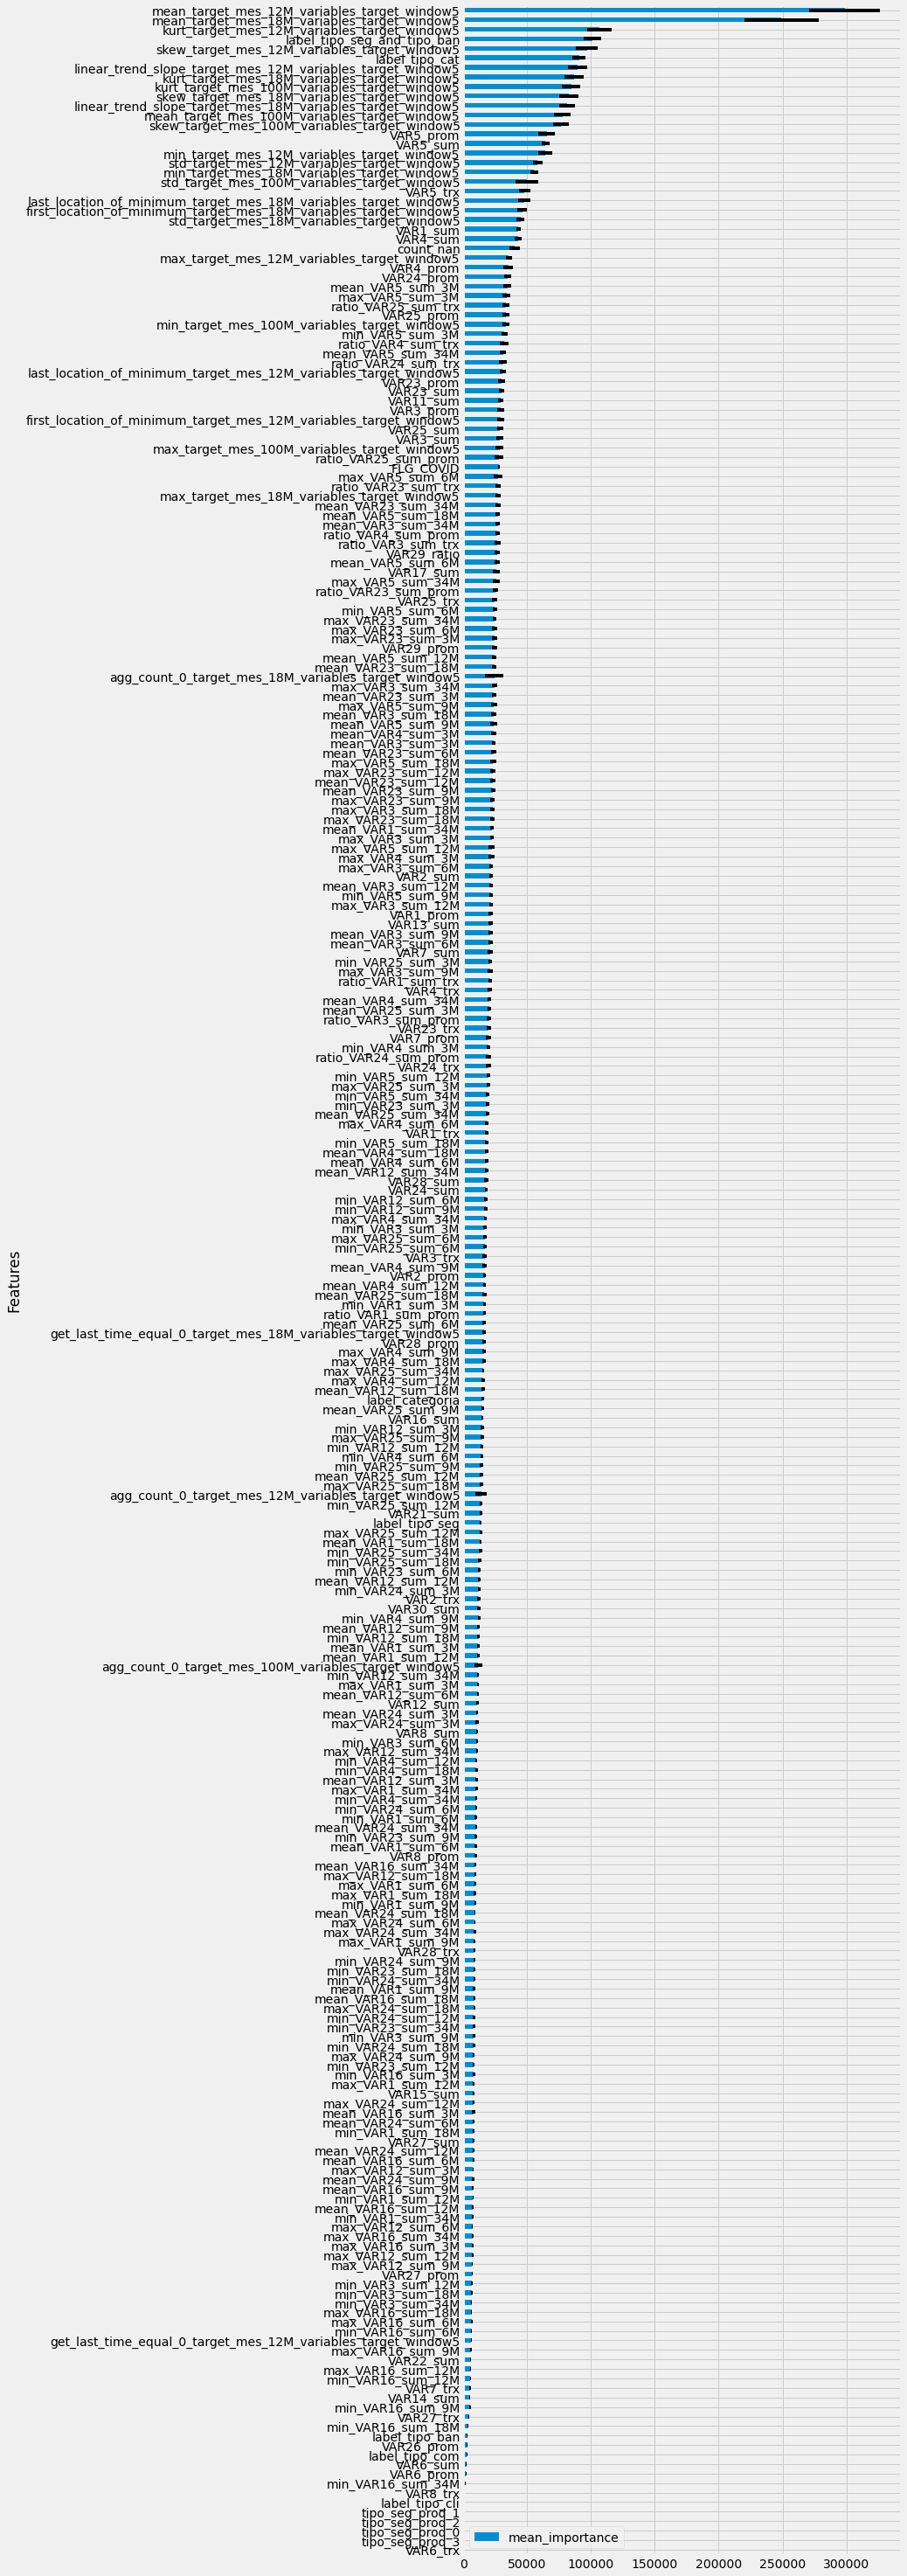

In [18]:
importance_df = trainer.get_importance(figsize=(8,50))

## Predict and Save Predictions

In [19]:
test_df['preds'] =  (trainer.predict(test_df,preds_returns = 'median')**2).clip(0)
test_df_part2  = test_all.merge(test_df[['id','mes','preds']],on = ['id','mes'],how = 'inner')
test_df_part2.head()

100%|██████████| 5/5 [00:49<00:00,  9.82s/it]


,id,mes,preds
0,8ae0058fa056,202105,19.868638
1,8a4fc1159dee,202106,72.393158
2,278764d539dd,202108,3.131776
3,59ec2caa4756,202107,24.144920
4,8a4fc1159dee,202105,80.192170


In [20]:
def save_model(trainer,train_df,test_df,model_path,group_name):
    import pickle
    output_folder = os.path.join(model_path,group_name)
    print('output_folder: ',output_folder)
    for fold,model in enumerate(trainer.models):
        os.makedirs(os.path.join(output_folder,f'fold_{fold}'), exist_ok=True)
        pickle.dump(model, open(os.path.join(output_folder,f'fold_{fold}','model.pkl'), 'wb'))
    train_df[['id','mes','oof']].to_csv(os.path.join(output_folder,'oof.csv'),index = False)
    test_df[['id','mes','preds']].to_csv(os.path.join(output_folder,'part2_test.csv'),index = False)
    print('Models Saved')

In [21]:
save_model(trainer,train_df,test_df,PATH_MODEL,GROUP_NAME)

output_folder:  ../../SavedModels/model_behavior/lightgbm_v0_behavior_mes_202004
Models Saved
